In [1]:
#importing libraries
import numpy as np 
import pandas as pd
from math import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score

import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 100)
import warnings
warnings.filterwarnings('ignore')        

#reading test and train dataset files
train = pd.read_csv("../input/blackfriday/train.csv")
test = pd.read_csv("../input/blackfriday/test.csv")

#creating dataframe for the required output
submission = pd.DataFrame()
submission['User_ID'] = test['User_ID']
submission['Product_ID'] = test['Product_ID']

**Label encoding** following columns : Gender, Age, City Category,Stay in Current City Years

In [2]:
gender_dict = {'F':0, 'M':1}
age_dict = {'0-17':0, '18-25':1, '26-35':2, '36-45':3, '46-50':4, '51-55':5, '55+':6}
city_dict = {'A':0, 'B':1, 'C':2}
stay_dict = {'0':0, '1':1, '2':2, '3':3, '4+':4}

train["Gender"] = train["Gender"].apply(lambda x: gender_dict[x])
test["Gender"] = test["Gender"].apply(lambda x: gender_dict[x])

train["Age"] = train["Age"].apply(lambda x: age_dict[x])
test["Age"] = test["Age"].apply(lambda x: age_dict[x])

train["City_Category"] = train["City_Category"].apply(lambda x: city_dict[x])
test["City_Category"] = test["City_Category"].apply(lambda x: city_dict[x])

train["Stay_In_Current_City_Years"] = train["Stay_In_Current_City_Years"].apply(lambda x: stay_dict[x])
test["Stay_In_Current_City_Years"] = test["Stay_In_Current_City_Years"].apply(lambda x: stay_dict[x])

**Feature Engineering**

Creating a **Count Column** for each caetgory

In [3]:
train["Age_Count"] = train.groupby(['Age'])['Age'].transform('count')
age_count_dict = train.groupby(['Age']).size().to_dict()
test['Age_Count'] = test['Age'].apply(lambda x:age_count_dict.get(x,0))

train["Occupation_Count"] = train.groupby(['Occupation'])['Occupation'].transform('count')
occupation_count_dict = train.groupby(['Occupation']).size().to_dict()
test['Occupation_Count'] = test['Occupation'].apply(lambda x:occupation_count_dict.get(x,0))

train["Product_Category_1_Count"] = train.groupby(['Product_Category_1'])['Product_Category_1'].transform('count')
pc1_count_dict = train.groupby(['Product_Category_1']).size().to_dict()
test['Product_Category_1_Count'] = test['Product_Category_1'].apply(lambda x:pc1_count_dict.get(x,0))

train["Product_Category_2_Count"] = train.groupby(['Product_Category_2'])['Product_Category_2'].transform('count')
pc2_count_dict = train.groupby(['Product_Category_2']).size().to_dict()
test['Product_Category_2_Count'] = test['Product_Category_2'].apply(lambda x:pc2_count_dict.get(x,0))

train["Product_Category_3_Count"] = train.groupby(['Product_Category_3'])['Product_Category_3'].transform('count')
pc3_count_dict = train.groupby(['Product_Category_3']).size().to_dict()
test['Product_Category_3_Count'] = test['Product_Category_3'].apply(lambda x:pc3_count_dict.get(x,0))

train["User_ID_Count"] = train.groupby(['User_ID'])['User_ID'].transform('count')
userID_count_dict = train.groupby(['User_ID']).size().to_dict()
test['User_ID_Count'] = test['User_ID'].apply(lambda x:userID_count_dict.get(x,0))

train["Product_ID_Count"] = train.groupby(['Product_ID'])['Product_ID'].transform('count')
productID_count_dict = train.groupby(['Product_ID']).size().to_dict()
test['Product_ID_Count'] = test['Product_ID'].apply(lambda x:productID_count_dict.get(x,0))

Creating **mean, max, min columns** on **Purchase** feature for each category

In [4]:
train["User_ID_MinPrice"] = train.groupby(['User_ID'])['Purchase'].transform('min')
userID_min_dict = train.groupby(['User_ID'])['Purchase'].min().to_dict()
test['User_ID_MinPrice'] = test['User_ID'].apply(lambda x:userID_min_dict.get(x,0))

train["User_ID_MaxPrice"] = train.groupby(['User_ID'])['Purchase'].transform('max')
userID_max_dict = train.groupby(['User_ID'])['Purchase'].max().to_dict()
test['User_ID_MaxPrice'] = test['User_ID'].apply(lambda x:userID_max_dict.get(x,0))

train["User_ID_MeanPrice"] = train.groupby(['User_ID'])['Purchase'].transform('mean')
userID_mean_dict = train.groupby(['User_ID'])['Purchase'].mean().to_dict()
test['User_ID_MeanPrice'] = test['User_ID'].apply(lambda x:userID_mean_dict.get(x,0))


train["Product_ID_MinPrice"] = train.groupby(['Product_ID'])['Purchase'].transform('min')
productID_min_dict = train.groupby(['Product_ID'])['Purchase'].min().to_dict()
test['Product_ID_MinPrice'] = test['Product_ID'].apply(lambda x:productID_min_dict.get(x,0))

train["Product_ID_MaxPrice"] = train.groupby(['Product_ID'])['Purchase'].transform('max')
productID_max_dict = train.groupby(['Product_ID'])['Purchase'].max().to_dict()
test['Product_ID_MaxPrice'] = test['Product_ID'].apply(lambda x:productID_max_dict.get(x,0))

train["Product_ID_MeanPrice"] = train.groupby(['Product_ID'])['Purchase'].transform('mean')
productID_mean_dict = train.groupby(['Product_ID'])['Purchase'].mean().to_dict()
test['Product_ID_MeanPrice'] = test['Product_ID'].apply(lambda x:productID_mean_dict.get(x,0))

Also, creating **25th and 75th percentile** columns on **Purchase** feature for each category

In [5]:
userID_25p_dict = train.groupby(['User_ID'])['Purchase'].apply(lambda x:np.percentile(x,25)).to_dict()
train['User_ID_25PercPrice'] = train['User_ID'].apply(lambda x:userID_25p_dict.get(x,0))
test['User_ID_25PercPrice'] = test['User_ID'].apply(lambda x:userID_25p_dict.get(x,0))

userID_75p_dict = train.groupby(['User_ID'])['Purchase'].apply(lambda x:np.percentile(x,75)).to_dict()
train['User_ID_75PercPrice'] = train['User_ID'].apply(lambda x:userID_75p_dict.get(x,0))
test['User_ID_75PercPrice'] = test['User_ID'].apply(lambda x:userID_75p_dict.get(x,0))

productID_25p_dict = train.groupby(['Product_ID'])['Purchase'].apply(lambda x:np.percentile(x,25)).to_dict()
train['Product_ID_25PercPrice'] = train['Product_ID'].apply(lambda x:productID_25p_dict.get(x,0))
test['Product_ID_25PercPrice'] = test['Product_ID'].apply(lambda x:productID_25p_dict.get(x,0))

productID_75p_dict = train.groupby(['Product_ID'])['Purchase'].apply(lambda x:np.percentile(x,75)).to_dict()
train['Product_ID_75PercPrice'] = train['Product_ID'].apply(lambda x:productID_75p_dict.get(x,0))
test['Product_ID_75PercPrice'] = test['Product_ID'].apply(lambda x:productID_75p_dict.get(x,0))


train["Product_Cat1_MinPrice"] = train.groupby(['Product_Category_1'])['Purchase'].transform('min')
pc1_min_dict = train.groupby(['Product_Category_1'])['Purchase'].min().to_dict()
test['Product_Cat1_MinPrice'] = test['Product_Category_1'].apply(lambda x:pc1_min_dict.get(x,0))

train["Product_Cat1_MaxPrice"] = train.groupby(['Product_Category_1'])['Purchase'].transform('max')
pc1_max_dict = train.groupby(['Product_Category_1'])['Purchase'].max().to_dict()
test['Product_Cat1_MaxPrice'] = test['Product_Category_1'].apply(lambda x:pc1_max_dict.get(x,0))

train["Product_Cat1_MeanPrice"] = train.groupby(['Product_Category_1'])['Purchase'].transform('mean')
pc1_mean_dict = train.groupby(['Product_Category_1'])['Purchase'].mean().to_dict()
test['Product_Cat1_MeanPrice'] = test['Product_Category_1'].apply(lambda x:pc1_mean_dict.get(x,0))

pc1_25p_dict = train.groupby(['Product_Category_1'])['Purchase'].apply(lambda x:np.percentile(x,25)).to_dict()
train['Product_Cat1_25PercPrice'] = train['Product_Category_1'].apply(lambda x:pc1_25p_dict.get(x,0))
test['Product_Cat1_25PercPrice'] = test['Product_Category_1'].apply(lambda x:pc1_25p_dict.get(x,0))

pc1_75p_dict = train.groupby(['Product_Category_1'])['Purchase'].apply(lambda x:np.percentile(x,75)).to_dict()
train['Product_Cat1_75PercPrice'] = train['Product_Category_1'].apply(lambda x:pc1_75p_dict.get(x,0))
test['Product_Cat1_75PercPrice'] = test['Product_Category_1'].apply(lambda x:pc1_75p_dict.get(x,0))


train["Product_Cat2_MinPrice"] = train.groupby(['Product_Category_2'])['Purchase'].transform('min')
pc2_min_dict = train.groupby(['Product_Category_2'])['Purchase'].min().to_dict()
test['Product_Cat2_MinPrice'] = test['Product_Category_2'].apply(lambda x:pc2_min_dict.get(x,0))

train["Product_Cat2_MaxPrice"] = train.groupby(['Product_Category_2'])['Purchase'].transform('max')
pc2_max_dict = train.groupby(['Product_Category_2'])['Purchase'].max().to_dict()
test['Product_Cat2_MaxPrice'] = test['Product_Category_2'].apply(lambda x:pc2_max_dict.get(x,0))

train["Product_Cat2_MeanPrice"] = train.groupby(['Product_Category_2'])['Purchase'].transform('mean')
pc2_mean_dict = train.groupby(['Product_Category_2'])['Purchase'].mean().to_dict()
test['Product_Cat2_MeanPrice'] = test['Product_Category_2'].apply(lambda x:pc2_mean_dict.get(x,0))

pc2_25p_dict = train.groupby(['Product_Category_2'])['Purchase'].apply(lambda x:np.percentile(x,25)).to_dict()
train['Product_Cat2_25PercPrice'] = train['Product_Category_2'].apply(lambda x:pc2_25p_dict.get(x,0))
test['Product_Cat2_25PercPrice'] = test['Product_Category_2'].apply(lambda x:pc2_25p_dict.get(x,0))

pc2_75p_dict = train.groupby(['Product_Category_2'])['Purchase'].apply(lambda x:np.percentile(x,75)).to_dict()
train['Product_Cat2_75PercPrice'] = train['Product_Category_2'].apply(lambda x:pc2_75p_dict.get(x,0))
test['Product_Cat2_75PercPrice'] = test['Product_Category_2'].apply(lambda x:pc2_75p_dict.get(x,0))


train["Product_Cat3_MinPrice"] = train.groupby(['Product_Category_3'])['Purchase'].transform('min')
pc3_min_dict = train.groupby(['Product_Category_3'])['Purchase'].min().to_dict()
test['Product_Cat3_MinPrice'] = test['Product_Category_3'].apply(lambda x:pc3_min_dict.get(x,0))

train["Product_Cat3_MaxPrice"] = train.groupby(['Product_Category_3'])['Purchase'].transform('max')
pc3_max_dict = train.groupby(['Product_Category_3'])['Purchase'].max().to_dict()
test['Product_Cat3_MaxPrice'] = test['Product_Category_3'].apply(lambda x:pc3_max_dict.get(x,0))

train["Product_Cat3_MeanPrice"] = train.groupby(['Product_Category_3'])['Purchase'].transform('mean')
pc3_mean_dict = train.groupby(['Product_Category_3'])['Purchase'].mean().to_dict()
test['Product_Cat3_MeanPrice'] = test['Product_Category_3'].apply(lambda x:pc3_mean_dict.get(x,0))

pc3_25p_dict = train.groupby(['Product_Category_3'])['Purchase'].apply(lambda x:np.percentile(x,25)).to_dict()
train['Product_Cat3_25PercPrice'] = train['Product_Category_3'].apply(lambda x:pc3_25p_dict.get(x,0))
test['Product_Cat3_25PercPrice'] = test['Product_Category_3'].apply(lambda x:pc3_25p_dict.get(x,0))

pc3_75p_dict = train.groupby(['Product_Category_3'])['Purchase'].apply(lambda x:np.percentile(x,75)).to_dict()
train['Product_Cat3_75PercPrice'] = train['Product_Category_3'].apply(lambda x:pc3_75p_dict.get(x,0))
test['Product_Cat3_75PercPrice'] = test['Product_Category_3'].apply(lambda x:pc3_75p_dict.get(x,0))

In [6]:
#seperating the dependant variable 
train_y = train["Purchase"]
train.drop(["Purchase"], axis=1, inplace=True)

#filling missing values in product categories 2 & 3 by by any constant number say -999
train.fillna(-999, inplace=True)
test.fillna(-999, inplace=True)

#label encoding User ID and Product ID
from sklearn.preprocessing import LabelEncoder
cat_columns_list = ["User_ID", "Product_ID"]
for var in cat_columns_list:
    lb = LabelEncoder()
    full_var_data = pd.concat((train[var],test[var]),axis=0).astype('str')
    temp = lb.fit_transform(np.array(full_var_data))
    train[var] = lb.transform(np.array( train[var] ).astype('str'))
    test[var] = lb.transform(np.array( test[var] ).astype('str'))

> *For All the models,*
1. Splitting Train set into train and validation set in 80:20 ratio
1. **Hyperparameter** have been found by checking **R2 & RMSE score on validation set** using **GridSearchCV**
1. Training the model with complete Train set and getting **predictions** for '**Purchase' feature** of Test set in a **.csv file**

** 1. Decision Tree Regressor**

In [7]:
X_train,X_test,Y_train,Y_test = train_test_split(train,train_y,test_size=0.2,random_state=42)

In [8]:
dtr = DecisionTreeRegressor(max_depth = 10)
dtr.fit(X_train,Y_train)
y_pred = dtr.predict(X_test)

# finding the mean_squared error
mse = mean_squared_error(Y_test, y_pred)
print("RMSE Error:", np.sqrt(mse))

# finding the r2 score or the variance
r2 = r2_score(Y_test, y_pred)
print("R2 Score:", r2)

RMSE Error: 2516.274639890895
R2 Score: 0.7480063393147172


**2. Linear Regression**

1. **One Hot Encoding** all Categorical features for all Linear models
1. Removing rows corresponding to the unique categorical values only available in train set, not in test set
1. **Removing outliers** rows by performing **boxplot analysis on Purchase** feature

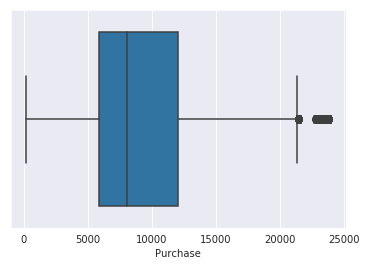

In [9]:
linear_test = test
linear_train = train

#dropping User ID and Product ID
linear_train = pd.concat([linear_train,train_y],1)
linear_train = linear_train.drop(['User_ID', 'Product_ID'],1)
linear_test = linear_test.drop(['User_ID', 'Product_ID'],1)

#removing rows corresponding to the unique categorical values only available in train set, not in test set
linear_train = linear_train.drop(linear_train[(linear_train['Product_Category_1']==19) | (linear_train['Product_Category_1']==20) | (linear_train['Product_Category_3']==2) | (linear_train['Product_Category_3']==7)].index)

sns.boxplot(linear_train['Purchase'])

q1 = linear_train['Purchase'].quantile(0.25)
q3 = linear_train['Purchase'].quantile(0.75)
iqr = q3-q1 #Interquartile range
fence_low  = q1-1.5*iqr
fence_high = q3+1.5*iqr
linear_train = linear_train[(linear_train['Purchase'] > fence_low) & (linear_train['Purchase'] < fence_high)]

#separating dependant variable
linear_train_y = linear_train["Purchase"]
linear_train.drop(["Purchase"], axis=1, inplace=True)

#chanding data type of categorical variable to string so as to one hot encode them using get_dummies
strlist = ['Gender', 'Age', 'Occupation', 'City_Category',
       'Stay_In_Current_City_Years', 'Marital_Status', 'Product_Category_1',
       'Product_Category_2', 'Product_Category_3']
for s in strlist:
    linear_train[s] = linear_train[s].astype(str)
    linear_test[s] = linear_test[s].astype(str)

In [10]:
#One Hot encoding categorical variables
linear_train = pd.get_dummies(linear_train, drop_first = True)
linear_test = pd.get_dummies(linear_test, drop_first = True)

In [11]:
#Scaling all the variables in range of 0 to 1
scaler = MinMaxScaler()
linear_train = scaler.fit_transform(linear_train)
linear_test = scaler.transform(linear_test)

Splitting into train and validation and appliing 4 Linear Models: 

In [12]:
X_train,X_test,Y_train,Y_test = train_test_split(linear_train,linear_train_y,test_size=0.2,random_state=42)

*Checking R2 and RMSE score on validation set for the below 4 linear models*

**2. Linear Regression**

In [13]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, Y_train)
y_pred = regressor.predict(X_test)

# finding the mean_squared error
mse = mean_squared_error(Y_test, y_pred)
print("RMSE Error:", np.sqrt(mse))

# finding the r2 score or the variance
r2 = r2_score(Y_test, y_pred)
print("R2 Score:", r2)

RMSE Error: 2545.477934726935
R2 Score: 0.7293623588176117


**3. Ridge**

In [14]:
regressor = Ridge(alpha = 10)
regressor.fit(X_train, Y_train)
y_pred = regressor.predict(X_test)

# finding the mean_squared error
mse = mean_squared_error(Y_test, y_pred)
print("RMSE Error:", np.sqrt(mse))

# finding the r2 score or the variance
r2 = r2_score(Y_test, y_pred)
print("R2 Score:", r2)

RMSE Error: 2545.7802043446345
R2 Score: 0.7292980798133992


**4. Lasso**

In [15]:
regressor = Lasso(alpha = 0.1)
regressor.fit(X_train, Y_train)
y_pred = regressor.predict(X_test)

# finding the mean_squared error
mse = mean_squared_error(Y_test, y_pred)
print("RMSE Error:", np.sqrt(mse))

# finding the r2 score or the variance
r2 = r2_score(Y_test, y_pred)
print("R2 Score:", r2)

RMSE Error: 2545.5381488193234
R2 Score: 0.7293495546267338


**5. Elastic Net**

In [16]:
regressor = ElasticNet(alpha = 0.05)
regressor.fit(X_train, Y_train)
regressor.fit(X_train, Y_train)
y_pred = regressor.predict(X_test)

# finding the mean_squared error
mse = mean_squared_error(Y_test, y_pred)
print("RMSE Error:", np.sqrt(mse))

# finding the r2 score or the variance
r2 = r2_score(Y_test, y_pred)
print("R2 Score:", r2)

RMSE Error: 2664.8044016231897
R2 Score: 0.7033938168945961


Boring Stuff Over, Now the fun begins

Creating **2 XGBoost Models** *both with* **different learning rates** *and* **different set of features** for both of them
1. XG Boost model 1 (learning rate = **0.5**), and features set = **alist + blist** (mentioned below)
1. XG Boost model 2 (learinng rate = **0.3**), and features set = **alist + **clist** (mentioned below)

In [17]:
alist = ['User_ID',
'Product_ID',
'Gender',
'Age',
'Occupation',
'City_Category',
'Stay_In_Current_City_Years',
'Marital_Status',
'Product_Category_1',
'Product_Category_2',
'Product_Category_3',
'Age_Count',
'Occupation_Count',
'Product_Category_1_Count',
'Product_Category_2_Count',
'Product_Category_3_Count',
'User_ID_Count',
'Product_ID_Count']
         
blist = ['User_ID_MinPrice',
'User_ID_MaxPrice',
'User_ID_MeanPrice',
'Product_ID_MinPrice',
'Product_ID_MaxPrice',
'Product_ID_MeanPrice']

clist = ['User_ID_25PercPrice',
'User_ID_75PercPrice',
'Product_ID_25PercPrice',
'Product_ID_75PercPrice',
'Product_Cat1_MinPrice',
'Product_Cat1_MaxPrice',
'Product_Cat1_MeanPrice',
'Product_Cat1_25PercPrice',
'Product_Cat1_75PercPrice',
'Product_Cat2_MinPrice',
'Product_Cat2_MaxPrice',
'Product_Cat2_MeanPrice',
'Product_Cat2_25PercPrice',
'Product_Cat2_75PercPrice',
'Product_Cat3_MinPrice',
'Product_Cat3_MaxPrice',
'Product_Cat3_MeanPrice',
'Product_Cat3_25PercPrice',
'Product_Cat3_75PercPrice']

In [18]:
#XGB model 1 dataframe
train1 = train[alist+blist]
test1 = test[alist+blist]

#XGB model 2 dataframe 
train2 = train[alist+clist]
test2 = test[alist+clist]

**6. XG Boost model 1**

Splitting into train and validation to calculate R2 & RMSE score on validation set

In [19]:
X_train,X_test,Y_train,Y_test = train_test_split(train1,train_y,test_size=0.2,random_state=42)

Learning rate is arbitrarily set and then other parameters are found using GridSearchCV by checking R2 score & RMSE on validation set, and some parameters are set as per the general standard

In [20]:
params = {}
params["eta"] = 0.05
params["min_child_weight"] = 10
params["subsample"] = 0.8
params["colsample_bytree"] = 0.7
params["max_depth"] = 10
params["seed"] = 0
plst = list(params.items())
num_rounds = 750

**Training the XG Boost model 1** with the above mentioned hyperparameters

In [21]:
#Takes 11 minutes to train
xgtrain = xgb.DMatrix(X_train, label=Y_train)
xgtest = xgb.DMatrix(X_test)
model1 = xgb.train(plst, xgtrain, num_rounds)

Checking the R2 and RMSE score on validation set using XG Boost model **1**

In [22]:
pred_test_y = model1.predict(xgtest)
from sklearn.metrics import mean_squared_error, r2_score
rmse = np.sqrt(mean_squared_error(pred_test_y, Y_test))
print("RMSE Score: ",rmse)
r2 = r2_score(Y_test, pred_test_y)

print("R2 Score:", r2)

#This will print
#RMSE Score:  2407.2232066688994
#R2 Score: 0.7693750669848086

RMSE Score:  2407.2232066688994
R2 Score: 0.7693750669848086


Getting the feature importance for XG Boost model **1** ,
* type of feature importance = 'gain’: the average gain across all splits the feature is used in

In [23]:
feature_important = model1.get_score(importance_type='gain')
keys = list(feature_important.keys())
values = list(feature_important.values())
total = sum(values)
new = [value * 100. / total for value in values]
new = np.round(new,2)

feature_importances = pd.DataFrame()
feature_importances['Features'] = keys
feature_importances['Importance (%)'] = new
feature_importances = feature_importances.sort_values(['Importance (%)'],ascending=False).reset_index(drop=True)
feature_importances
feature_importances.style.set_properties(**{'font-size':'10pt'})

,Features,Importance (%)
0,Product_ID_MeanPrice,48.38
1,Product_ID_MaxPrice,23.96
2,User_ID_MeanPrice,3.31
3,Product_ID_MinPrice,2.35
4,Product_Category_1_Count,1.75
5,Product_Category_1,1.66
6,User_ID_MaxPrice,1.41
7,Gender,1.39
8,User_ID_Count,1.21
9,Product_ID_Count,1.16


Plotting the Feature importane on a scale of 0 to 100 (total combined features impoprtance =100)

Text(0, 0.5, 'Features')

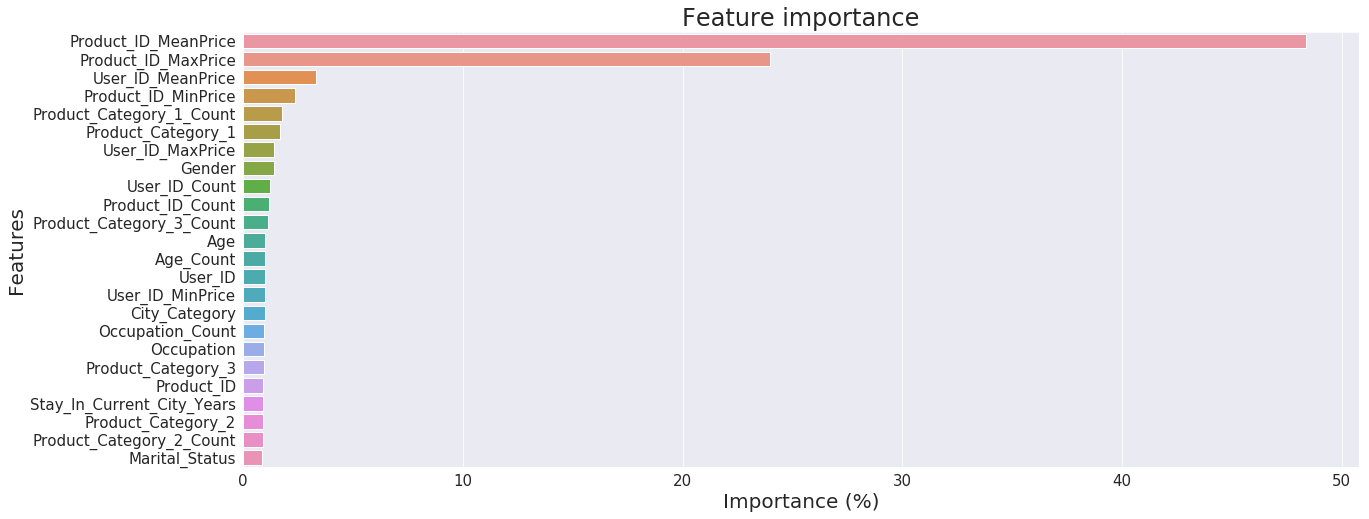

In [24]:
plt.figure(figsize=(20, 8))
sns.barplot(data=feature_importances, x='Importance (%)', y='Features');
plt.title('Feature importance',fontsize=24)
plt.xlabel('Importance (%)',fontsize=20)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.ylabel('Features',fontsize=20)

Generating predctions of Purchase feature on test set and exporting it to a csv file

In [25]:
#This will take 17 mins to run
xgtrain = xgb.DMatrix(train, label=train_y)
xgtest = xgb.DMatrix(test)
model1 = xgb.train(plst, xgtrain, num_rounds)

#prediction1
pred_xgb_m1 = model1.predict(xgtest)
submission['Purchase'] = pred_xgb_m1
submission.to_csv('xgb_model1.csv',index=False)

**7. XG Boost model 2** (same as above, but with different hyperparameters and different set of features)

In [26]:
X_train,X_test,Y_train,Y_test = train_test_split(train2,train_y,test_size=0.2,random_state=42)

In [27]:
#These parameters are found using GridSearchCV by checking R2 score & RMSE on validation set
params = {}
params["eta"] = 0.03
params["min_child_weight"] = 10
params["subsample"] = 0.8
params["colsample_bytree"] = 0.7
params["max_depth"] = 10
params["seed"] = 0
plst = list(params.items())
num_rounds = 1100
import xgboost as xgb
xgtrain = xgb.DMatrix(X_train, label=Y_train)
xgtest = xgb.DMatrix(X_test)

In [28]:
#Takes 18 minutes to train
model2 = xgb.train(plst, xgtrain, num_rounds)

Checking the R2 and RMSE score on validation set using XG Boost model **2**

In [29]:
pred_test_y = model2.predict(xgtest)
from sklearn.metrics import mean_squared_error, r2_score
rmse = np.sqrt(mean_squared_error(pred_test_y, Y_test))
print("RMSE Score: ",rmse)
r2 = r2_score(Y_test, pred_test_y)

print("R2 Score:", r2)

#This will print
#RMSE Score:  2415.988043238194
#R2 Score: 0.7676925725333128

RMSE Score:  2415.988043238194
R2 Score: 0.7676925725333128


Getting the feature importance for XG Boost model **2** ,
* type of feature importance = 'gain’: the average gain across all splits the feature is used in

In [30]:
feature_important = model2.get_score(importance_type='gain')
keys = list(feature_important.keys())
values = list(feature_important.values())
total = sum(values)
new = [value * 100. / total for value in values]
new = np.round(new,2)

feature_importances = pd.DataFrame()
feature_importances['Features'] = keys
feature_importances['Importance (%)'] = new
feature_importances = feature_importances.sort_values(['Importance (%)'],ascending=False).reset_index(drop=True)
feature_importances
feature_importances.style.set_properties(**{'font-size':'10pt'})

,Features,Importance (%)
0,Product_Cat1_MinPrice,35.73
1,Product_ID_75PercPrice,25.42
2,Product_Cat1_MaxPrice,8.61
3,Product_ID_25PercPrice,6.07
4,Product_Cat1_MeanPrice,4.06
5,Product_Category_1_Count,2.81
6,Product_Cat1_25PercPrice,1.18
7,User_ID_75PercPrice,1.12
8,User_ID_25PercPrice,1.12
9,Product_Category_1,0.81


Plotting the Feature importane on a scale of 0 to 100 (total combined features impoprtance =100)

Text(0, 0.5, 'Features')

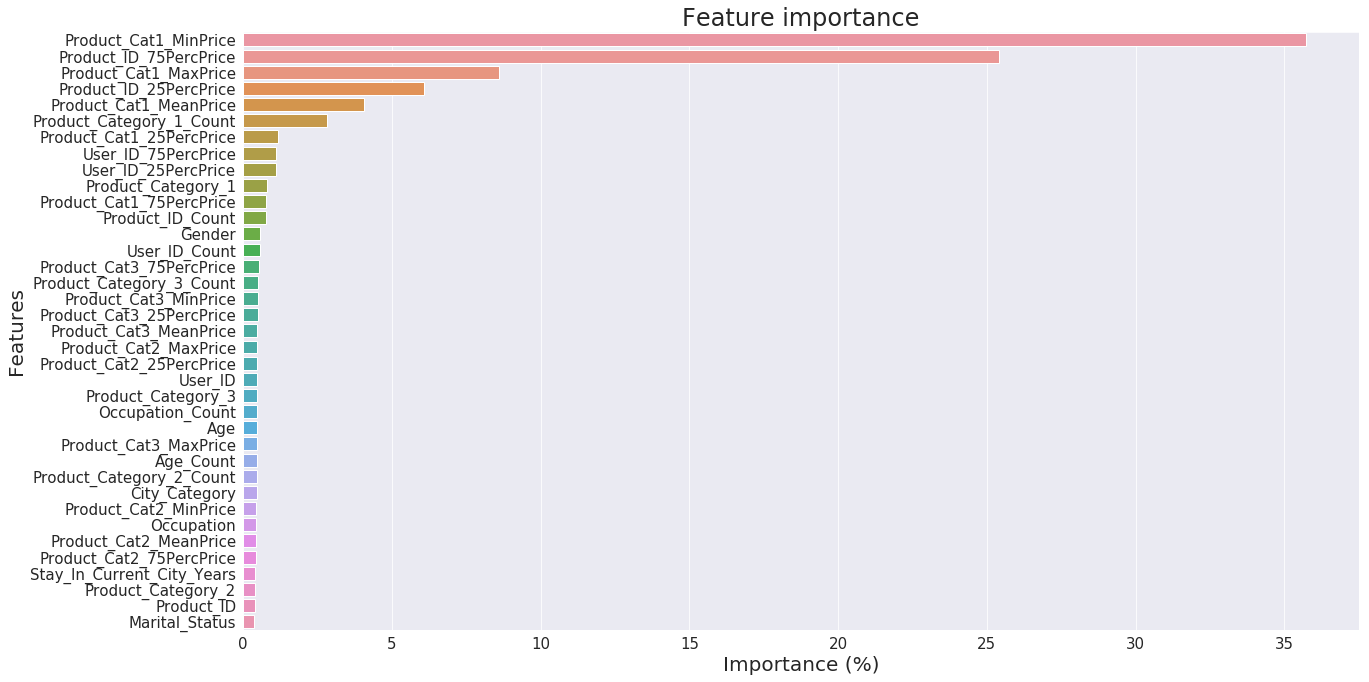

In [31]:
plt.figure(figsize=(20, 11))
sns.barplot(data=feature_importances, x='Importance (%)', y='Features');
plt.title('Feature importance',fontsize=24)
plt.xlabel('Importance (%)',fontsize=20)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.ylabel('Features',fontsize=20)

Generating XG Boost model 2 predictions

In [32]:
xgtrain = xgb.DMatrix(train2, label=train_y)
xgtest = xgb.DMatrix(test2)
model2 = xgb.train(plst, xgtrain, num_rounds)

#prediction2
pred_xgb_m2 = model2.predict(xgtest)
submission['Purchase'] = pred_xgb_m2
submission.to_csv('xgb_model2.csv',index=False)

**Ensemble Model**

Weighted Average of the above 2 XG Boost models

In [33]:
submission['Purchase'] = 0.3*pred_xgb_m1 + 0.7*pred_xgb_m2
submission.to_csv('A016AmanJain.csv',index=False)